# Final Project Notebook

# Data Processing and Cleaning

In [2]:
import re
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score

In [3]:
from nltk.sentiment import SentimentIntensityAnalyzer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import nltk

nltk.download('stopwords')
nltk.download('punkt')

sia = SentimentIntensityAnalyzer()

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\zhzha\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\zhzha\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [4]:
data = pd.read_csv(r"C:\Users\zhzha\Downloads\stock_tweets.csv")
data.head()

,Date,Tweet,Stock Name,Company Name
0,2022-09-29 23:41:16+00:00,Mainstream media has done an amazing job at br...,TSLA,"Tesla, Inc."
1,2022-09-29 23:24:43+00:00,Tesla delivery estimates are at around 364k fr...,TSLA,"Tesla, Inc."
2,2022-09-29 23:18:08+00:00,3/ Even if I include 63.0M unvested RSUs as of...,TSLA,"Tesla, Inc."
3,2022-09-29 22:40:07+00:00,@RealDanODowd @WholeMarsBlog @Tesla Hahaha why...,TSLA,"Tesla, Inc."
4,2022-09-29 22:27:05+00:00,"@RealDanODowd @Tesla Stop trying to kill kids,...",TSLA,"Tesla, Inc."


In [5]:
def clean_text(text):
    # Remove URLs
    text = re.sub(r'http\S+', '', text) 
    # Remove mentions@
    text = re.sub(r'@\w+', '', text)
    # Remove non-alphanumeric characters
    text = re.sub(r'[^a-zA-Z\s]', '', text) 
    # Convert to lowercase
    text = text.lower()
    return text

data['cleaned_tweet'] = data['Tweet'].apply(clean_text)

In [6]:
def remove_stopwords(text):
    # Get the list of English stopwords
    stop_words = set(stopwords.words('english'))
     # Tokenize the text into words
    words = word_tokenize(text)
     # Remove stopwords
    filtered_words = [word for word in words if word not in stop_words]
    return ' '.join(filtered_words)

data['cleaned_tweet'] = data['cleaned_tweet'].apply(remove_stopwords)

In [7]:
def get_sentiment(tweet):
    score = sia.polarity_scores(tweet)['compound']
    if score > 0.05:  
        return 2  # Positive sentiment
    elif score < -0.05:
        return 0  # Negative sentiment
    else:
        return 1  # Neutral sentiment
    
data['sentiment'] = data['cleaned_tweet'].apply(get_sentiment)

In [8]:
# Split the data into training and testing sets
# random_state=42 to make results consistent every code run.
X_train, X_test, y_train, y_test = train_test_split(data['cleaned_tweet'], data['sentiment'], test_size=0.2, random_state=42)

# Exploratory Analysis

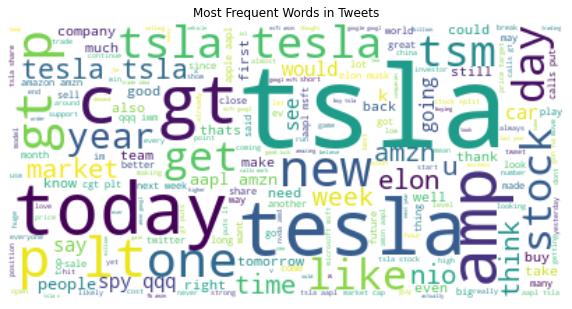

In [9]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
# Combine all tweets into a single string
all_text = ' '.join(data['cleaned_tweet'])

# Created and displayed a word cloud using the combined text
wordcloud = WordCloud(stopwords=stopwords.words('english'), background_color='white').generate(all_text)

plt.figure(figsize=(10,8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Most Frequent Words in Tweets')
plt.show()


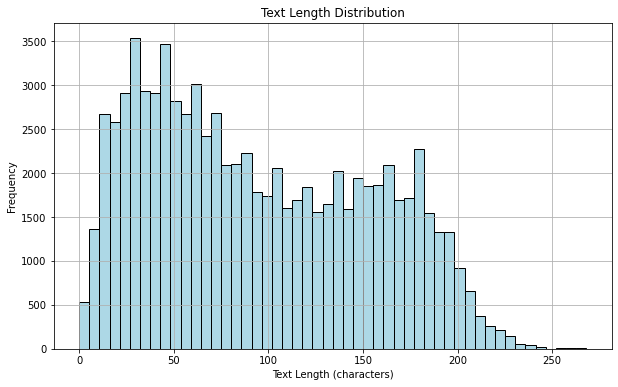

In [10]:
# Get the length of each cleaned tweet and store it in a new column
data['text_length'] = data['cleaned_tweet'].apply(len)

# Plot the distribution of text lengths
plt.figure(figsize=(10,6))
plt.hist(data['text_length'], bins=50, color='lightblue', edgecolor='black')
plt.title('Text Length Distribution')
plt.xlabel('Text Length (characters)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()


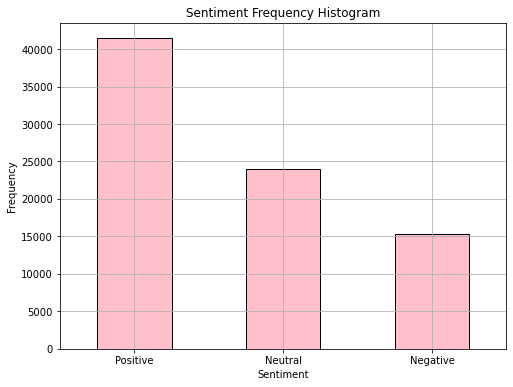

In [11]:
# Plot sentiment distribution as a bar chart
plt.figure(figsize=(8,6))
data['sentiment'].value_counts().plot(kind='bar', color='pink', edgecolor='black')
plt.title('Sentiment Frequency Histogram')
plt.xlabel('Sentiment')
plt.ylabel('Frequency')
plt.xticks(ticks=[0, 1, 2], labels=[ 'Positive', 'Neutral', 'Negative'], rotation=0)
plt.grid(True)
plt.show()


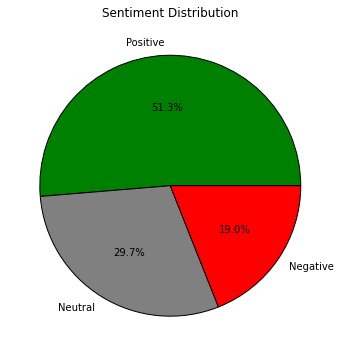

In [12]:
# Plot sentiment distribution as a pie chart
plt.figure(figsize=(8,6))
sentiment_counts = data['sentiment'].value_counts()
plt.pie(sentiment_counts, labels=[ 'Positive', 'Neutral', 'Negative'], autopct='%1.1f%%', colors=['green', 'gray', 'red'], wedgeprops={'edgecolor': 'black'})
plt.title('Sentiment Distribution')
plt.show()


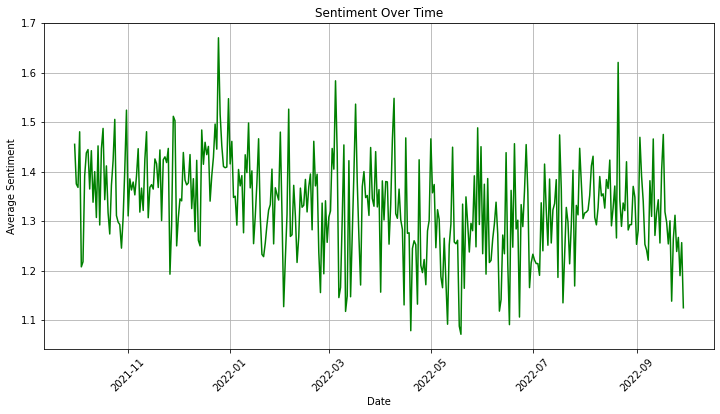

In [13]:
# Change the 'Date' to datetime format
data['Date'] = pd.to_datetime(data['Date'])

# Calculate the average sentiment for each day
daily_sentiment = data.groupby(data['Date'].dt.date)['sentiment'].mean()


plt.figure(figsize=(12,6))
daily_sentiment.plot(color='green')
plt.title('Sentiment Over Time')
plt.xlabel('Date')
plt.ylabel('Average Sentiment')
plt.grid(True)
plt.xticks(rotation=45)
plt.show()


# Methodology & Models

## Random Forest Model

In [14]:
from sklearn.ensemble import RandomForestClassifier

# Transform the training data into TF-IDF features
tfidf = TfidfVectorizer(max_features=5000, stop_words='english')
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)


In [15]:
# Train the Random Forest model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_tfidf, y_train)

# Predict with the trained model
rf_preds = rf_model.predict(X_test_tfidf)

In [16]:
print("Random Forest Results:")
print(classification_report(y_test, rf_preds))

rf_accuracy = accuracy_score(y_test, rf_preds)
print(f"Random Forest Accuracy: {rf_accuracy}")

Random Forest Results:
              precision    recall  f1-score   support

           0       0.89      0.64      0.74      3089
           1       0.82      0.93      0.87      4826
           2       0.88      0.91      0.90      8244

    accuracy                           0.86     16159
   macro avg       0.87      0.83      0.84     16159
weighted avg       0.87      0.86      0.86     16159

Random Forest Accuracy: 0.8634816510922706


## XGBoost Model

In [17]:
from xgboost import XGBClassifier
import xgboost as xgb

# Tain the XGBoost model
xgb_model = xgb.XGBClassifier(
    eval_metric='mlogloss', 
    num_class=3,
    random_state=42
)

xgb_model.fit(X_train_tfidf, y_train)

# Predict with the trained XGBoost model
xgb_preds = xgb_model.predict(X_test_tfidf)


In [18]:
print("XGBoost Results:")
print(classification_report(y_test, xgb_preds))

xgb_accuracy = accuracy_score(y_test, xgb_preds)
print(f"XGBoost Accuracy: {xgb_accuracy}")

XGBoost Results:
              precision    recall  f1-score   support

           0       0.87      0.51      0.64      3089
           1       0.72      0.92      0.81      4826
           2       0.86      0.86      0.86      8244

    accuracy                           0.81     16159
   macro avg       0.82      0.76      0.77     16159
weighted avg       0.82      0.81      0.80     16159

XGBoost Accuracy: 0.8080945603069497


## LightGBM Model

In [19]:
import lightgbm as lgb

# Convert TF-IDF to dense array
X_train1 = X_train_tfidf.toarray()
X_test1 = X_test_tfidf.toarray()

# Create a LightGBM Dataset
train_lgb = lgb.Dataset(X_train1, label=y_train)
test_lgb = lgb.Dataset(X_test1, label=y_test)

lgb_params = {
    'objective': 'multiclass',
    'num_class': 3,
    'metric': 'multi_logloss', 
    'random_state': 42
}

In [21]:
# Train the model
lgb_model = lgb.train(
    lgb_params,
    train_lgb,
    # Number of boosting iterations
    num_boost_round=100, 
     # Validation data for early stopping
    valid_sets=[test_lgb], 
     # Early stopping and logging every 10 rounds
    callbacks=[lgb.early_stopping(stopping_rounds=50), lgb.log_evaluation(10)],
)


lgb_preds = np.argmax(lgb_model.predict(X_test1), axis=1)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.208321 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 182573
[LightGBM] [Info] Number of data points in the train set: 64634, number of used features: 4787
[LightGBM] [Info] Start training from score -1.663541
[LightGBM] [Info] Start training from score -1.215029
[LightGBM] [Info] Start training from score -0.665859
Training until validation scores don't improve for 50 rounds
[10]	valid_0's multi_logloss: 0.792564
[20]	valid_0's multi_logloss: 0.704192
[30]	valid_0's multi_logloss: 0.649362
[40]	valid_0's multi_logloss: 0.611509
[50]	valid_0's multi_logloss: 0.5826
[60]	valid_0's multi_logloss: 0.558974
[70]	valid_0's multi_logloss: 0.539605
[80]	valid_0's multi_logloss: 0.522954
[90]	valid_0's multi_logloss: 0.508363
[100]	valid_0's multi_logloss: 0.49566
Did not meet early stopping. Bes

In [22]:
print("LightGBM Results:")
print(classification_report(y_test, lgb_preds))

print(f"LightGBM Accuracy: {accuracy_score(y_test, lgb_preds)}")

LightGBM Results:
              precision    recall  f1-score   support

           0       0.86      0.61      0.72      3089
           1       0.77      0.95      0.85      4826
           2       0.91      0.88      0.89      8244

    accuracy                           0.85     16159
   macro avg       0.85      0.81      0.82     16159
weighted avg       0.86      0.85      0.85     16159

LightGBM Accuracy: 0.8485673618416981


## CNN Model

In [65]:
# Some tutorials I read: the https://pub.towardsai.net/how-to-set-up-and-run-cuda-operations-in-pytorch-c5363f73a18e 
# https://galhever.medium.com/sentiment-analysis-with-pytorch-part-3-cnn-model-7bb30712abd7

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset


# Data preprocessing: Convert text to indices
vocab = set(" ".join(data['cleaned_tweet']).split())  # Vocabulary set
idx1 = {word: idx + 1 for idx, word in enumerate(vocab)}  # Change Word to index
Unknown = len(to_idx) + 1  # Unknown token
max_length = max(data['cleaned_tweet'].apply(lambda x: len(x.split())))

In [66]:
# Convert text to sequence of indices
def text_to_sequence(text):
    return [idx1.get(word, Unknown) for word in text.split()] + [0] * (max_length - len(text.split()))

data['sequence'] = data['cleaned_tweet'].apply(text_to_sequence)

X_train, X_test, y_train, y_test = train_test_split(data['sequence'], data['sentiment'], test_size=0.2, random_state=42)

# Convert data to  tensors
X_train2 = torch.tensor(X_train.tolist())
X_test2 = torch.tensor(X_test.tolist())
y_train2 = torch.tensor(y_train.tolist())
y_test2 = torch.tensor(y_test.tolist())

train_loader = DataLoader(TensorDataset(X_train2, y_train2), batch_size=64, shuffle=True)
test_loader = DataLoader(TensorDataset(X_test2, y_test2), batch_size=64, shuffle=False)

In [67]:
# Define the CNN model
class CNN(nn.Module):
    def __init__(self, vocab_size, embed_size, num_classes):
        super(CNN, self).__init__()
         # Embedding layer for word representations
        self.embedding = nn.Embedding(vocab_size, embed_size) 
         # Single convolutional layer
        self.conv = nn.Conv2d(1, 100, (3, embed_size)) 
        self.fc = nn.Linear(100, num_classes)  

    def forward(self, x):
        x = self.embedding(x).unsqueeze(1) 
        x = torch.relu(self.conv(x)).squeeze(3)  
        # Max pooling operation to capture features
        x = torch.max(x, dim=2)[0]  
        return self.fc(x)  

In [68]:
vocab_size = len(to_idx) + 1  
model = CNN(vocab_size, 100, 3)  

# Training setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [69]:
# Trian CNN model
for epoch in range(5):
    model.train()
    total_loss, correct_preds, total_preds = 0, 0, 0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        output = model(X_batch)
        loss = criterion(output, y_batch)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        correct_preds += (output.argmax(1) == y_batch).sum().item()
        total_preds += y_batch.size(0)

    print(f'Epoch {epoch+1}, Loss: {total_loss/len(train_loader):.4f}, Accuracy: {correct_preds/total_preds:.4f}')

model.eval()
correct_preds, total_preds, y_true, y_pred = 0, 0, [], []
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        output = model(X_batch)
        preds = output.argmax(1)
        correct_preds += (preds == y_batch).sum().item()
        total_preds += y_batch.size(0)
        y_true.extend(y_batch.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

Epoch 1, Loss: 0.6969, Accuracy: 0.7073
Epoch 2, Loss: 0.3980, Accuracy: 0.8587
Epoch 3, Loss: 0.2439, Accuracy: 0.9229
Epoch 4, Loss: 0.1446, Accuracy: 0.9588
Epoch 5, Loss: 0.0788, Accuracy: 0.9808


In [70]:
print("CNN Results:")
print(classification_report(y_true, y_pred))
print(f'CNN Accuracy: {correct_preds/total_preds:.4f}')

CNN Results:
              precision    recall  f1-score   support

           0       0.77      0.74      0.75      3089
           1       0.88      0.86      0.87      4826
           2       0.90      0.92      0.91      8244

    accuracy                           0.87     16159
   macro avg       0.85      0.84      0.84     16159
weighted avg       0.87      0.87      0.87     16159

CNN Accuracy: 0.8686


# Performance Comparison

In [71]:
# Overall classification reports for all models

cnn_report = classification_report(y_true, y_pred, output_dict=True)
rf_report = classification_report(y_test, rf_preds, output_dict=True)
xgb_report = classification_report(y_test, xgb_preds, output_dict=True)
lgb_report = classification_report(y_test, lgb_preds, output_dict=True)

models = ['Random Forest + TF-IDF', 'XGBoost + TF-IDF', 'LightGBM + TF-IDF', 'CNN + Word Embeddings']
metrics = ['precision', 'recall', 'f1-score', 'support']

# Create dictionaries to store the results
macro_results = {}
weighted_results = {}
accuracy_results = {}

In [72]:
# Add the metrics
for model, report in zip(models, [rf_report, xgb_report, lgb_report, cnn_report]):
    if model == 'Random Forest + TF-IDF':
        preds = rf_preds
    elif model == 'XGBoost + TF-IDF':
        preds = xgb_preds
    elif model == 'LightGBM + TF-IDF':
        preds = lgb_preds
    elif model == 'CNN + Word Embeddings':
        preds = y_pred 
    
    # add the metrics for macro and weighted averages report
    macro_results[model] = {metric: report['macro avg'][metric] for metric in metrics}
    weighted_results[model] = {metric: report['weighted avg'][metric] for metric in metrics}
    
    accuracy_results[model] = accuracy_score(y_test, preds)

In [73]:
macro_df = pd.DataFrame(macro_results).transpose()
weighted_df = pd.DataFrame(weighted_results).transpose()

accuracy_df = pd.DataFrame(list(accuracy_results.items()), columns=['Model', 'Accuracy'])
accuracy_df.set_index('Model', inplace=True)

print("\nAccuracy Report:")
print(accuracy_df)


Accuracy Report:
                        Accuracy
Model                           
Random Forest + TF-IDF  0.863482
XGBoost + TF-IDF        0.808095
LightGBM + TF-IDF       0.848567
CNN + Word Embeddings   0.868618


In [74]:
print("Macro Accuracy Report:")
print(macro_df)

Macro Accuracy Report:
                        precision    recall  f1-score  support
Random Forest + TF-IDF   0.865761  0.825177  0.837148  16159.0
XGBoost + TF-IDF         0.816644  0.760926  0.769350  16159.0
LightGBM + TF-IDF        0.845478  0.814051  0.819314  16159.0
CNN + Word Embeddings    0.849067  0.841139  0.844919  16159.0


In [75]:
print("\nWeighted Accuracy Report:")
print(weighted_df)


Weighted Accuracy Report:
                        precision    recall  f1-score  support
Random Forest + TF-IDF   0.866398  0.863482  0.859749  16159.0
XGBoost + TF-IDF         0.819990  0.808095  0.801653  16159.0
LightGBM + TF-IDF        0.856374  0.848567  0.845314  16159.0
CNN + Word Embeddings    0.867759  0.868618  0.868006  16159.0
